<a href="https://colab.research.google.com/github/KeanuInterone/AutonomousDrivingGamePlayer/blob/main/AutonomousGamePlayerDataProcessor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#⚙️ Welcome to the Game Recording Data Processor ⚙️

This notebook is purpose built to process the recordings generated from the **Autonomous Game Player Framework** to create ready to use training data for our models. 🏋️

In brief, the Autonomous Game Player Framework is a set of python files that allows you to create recordings of yourself playing a game on your computer. Then, with those recordings, train a model to make action predictions so that you can execute the model in the framework to play the game autonomously. 🤖

This notebook is solely for the purpose of preprocessing the recordings we generated from the framework. This notebook will generate the data that we will use to train a model. The model training code will be in a separate notebook.

This notebook was specifically designed to create the training data for a driving game, but should be easily modified to fit your use case if need be. By the end of this notebook we will have gone from the raw recordings, to training examples, to batched files.

Let's get into it!!


### Imports

In [1]:
import pickle
from matplotlib import pyplot as plt
import numpy as np
import os
import time
import gc
from multiprocessing import Pool

### Configure

In [2]:
recordings_dir = '/content/drive/MyDrive/Projects/AutonomousGamePlayer/RallyRacerDirtRecordings'
examples_dir = '/content/drive/MyDrive/Projects/AutonomousGamePlayer/Examples'
batched_examples_dir = '/content/drive/MyDrive/Projects/AutonomousGamePlayer/BatchedExamples'
window_size = 20
step_size = 1
batch_size = 32
np.random.seed(69)

# The Recordings

To start, we'll have a look at a single recording outputted from the framework. A recording is simply a pickle file containing a dictionary with the keys `screen_frames` and `key_frames`. `screen_frames` is the array containing the sequence of images recorded as you played the game and `key_frames` is the array of recorded key states at each timestep of the recording. A `1` in the key state array denotes that a key was pressed and a `0` denotes that the key was not pressed. Each key that was recorded has its own index in the array to record its state. In the following recordings, the order of keys is in a key state is [⬆️, ⬅️, ➡️, ⬇️] for the arrow keys that I used to play the driving game.


### Get the list of pickle files in a directory

In [3]:
def get_pickle_file_paths(dir):
  """
  Gets the list of pickle files in a directory
  ARGS:
    dir (string): Directory
  RETURNS:
    file_names (list): List of file names
  """
  file_names = []
  for filename in os.listdir(dir):
    if filename.endswith('.pickle'):
      path = os.path.join(dir, filename)
      file_names.append(path)
  return file_names

In [4]:
# Get the recording file paths from the recordings dir
recording_file_paths = get_pickle_file_paths(recordings_dir)

In [5]:
print(f'Number of files: {len(recording_file_paths)}')

Number of files: 3


### Load a pickle object

In [6]:
def load_pickle_object(file_path):
  """
  Loads and returns the object from a pickle file
  ARGS:
    file_path (string): File path
  RETURNS:
    object (dict): the pickled object
  """
  # Open file
  with open(file_path, 'rb') as handle:
    # Load data
    pickle_object = pickle.load(handle)
    return pickle_object

### Save a pickle object

In [7]:
def save_pickle_object(object, file_name):
  """
  Saves a pickle object
  ARGS:
    object (dict): the pickled object
    file_name (string): File name
  """
  # Open file
  with open(file_name, 'wb') as handle:
    # Save data
    pickle.dump(object, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
# As an example, load the a recording object
recording = load_pickle_object(recording_file_paths[1])

# Print the objects keys
print(recording.keys())

dict_keys(['key_frames', 'screen_frames'])


In [9]:
# Print the shapes of screen_frames and key_frames
print(f"Screen Frames Shape: {recording['screen_frames'].shape}")
print(f"Key Frames Shape: {recording['key_frames'].shape}")

Screen Frames Shape: (478, 256, 256, 3)
Key Frames Shape: (478, 4)


#Shapes

In this particular example the shapes in the first recording were as follows...

`478` being the number of frames recorded

`256, 256, 3` being the RGB images

`4` being the number of keys in a key state. In this case the 4 keys in a key state being ⬆️ ⬅️ ➡️ ⬇️ in that order




# Let's have a look at the recording

### Display Images Function

In [10]:
def display_images(
    images,
    labels=None,
    label_title='Label',
    prediction_labels=None,
    prediction_label_title='Prediction',
    n=10,
    random=False
    ):
  """
  Displays a list of images
  ARGS:
    images (list): List of images
    labels (list, optional): List of labels
    label_title (string, optional): Label title
    prediction_labels (list, optional): List of prediction labels
    prediction_label_title (string, optional): Prediction label title
    n (int, optional): Number of images to display
    random (bool, optional): Whether to randomize
  """
  # If random
  if random:
    random_indices = np.random.choice(len(images), n)
    images = images[random_indices]
    if labels is not None:
      labels = labels[random_indices]
    if prediction_labels is not None:
      prediction_labels = prediction_labels[random_indices]

  # n images and labels
  images = images[:n]
  if labels is not None:
    labels = labels[:n]
  if prediction_labels is not None:
    prediction_labels = prediction_labels[:n]

  # Normalize
  if images.max() > 1.0:
    images = images / 255.0

  # Rows and columns
  columns = 5
  rows = len(images) // columns + 1 if len(images) % columns != 0 else len(images) // columns

  # Plot width and height
  width = 15
  height = 4 * rows

  # Create figure and axes
  fig, axes = plt.subplots(rows, columns, figsize=(width, height))

  # Loop over plots
  for i, ax in enumerate(axes.flat):
    # Hide axis
    ax.set_xticks([])
    ax.set_yticks([])
    # Skip if no image
    if i >= len(images):
      continue
    # Set title
    title = ''
    if labels is not None:
      title += f'{label_title}: {labels[i]}\n'
    if prediction_labels is not None:
      title += f'{prediction_label_title}: {prediction_labels[i]}'
    ax.set_title(title)
    # Show image
    ax.imshow(images[i])


  plt.show()

### Show recording

In [11]:
def show_recording(recording, start_frame=0, n=20):
  """
  Displays a recording
  ARGS:
    recording (dict): Recording
    start_frame (int, optional): Start frame
    n (int, optional): Number of frames to display
  """
  key_frames = [str(key_frame) for key_frame in recording['key_frames'][start_frame:start_frame+n]]
  screen_frames = recording['screen_frames'][start_frame:start_frame+n]
  display_images(screen_frames, labels=key_frames, label_title='Key Frame', n=n)

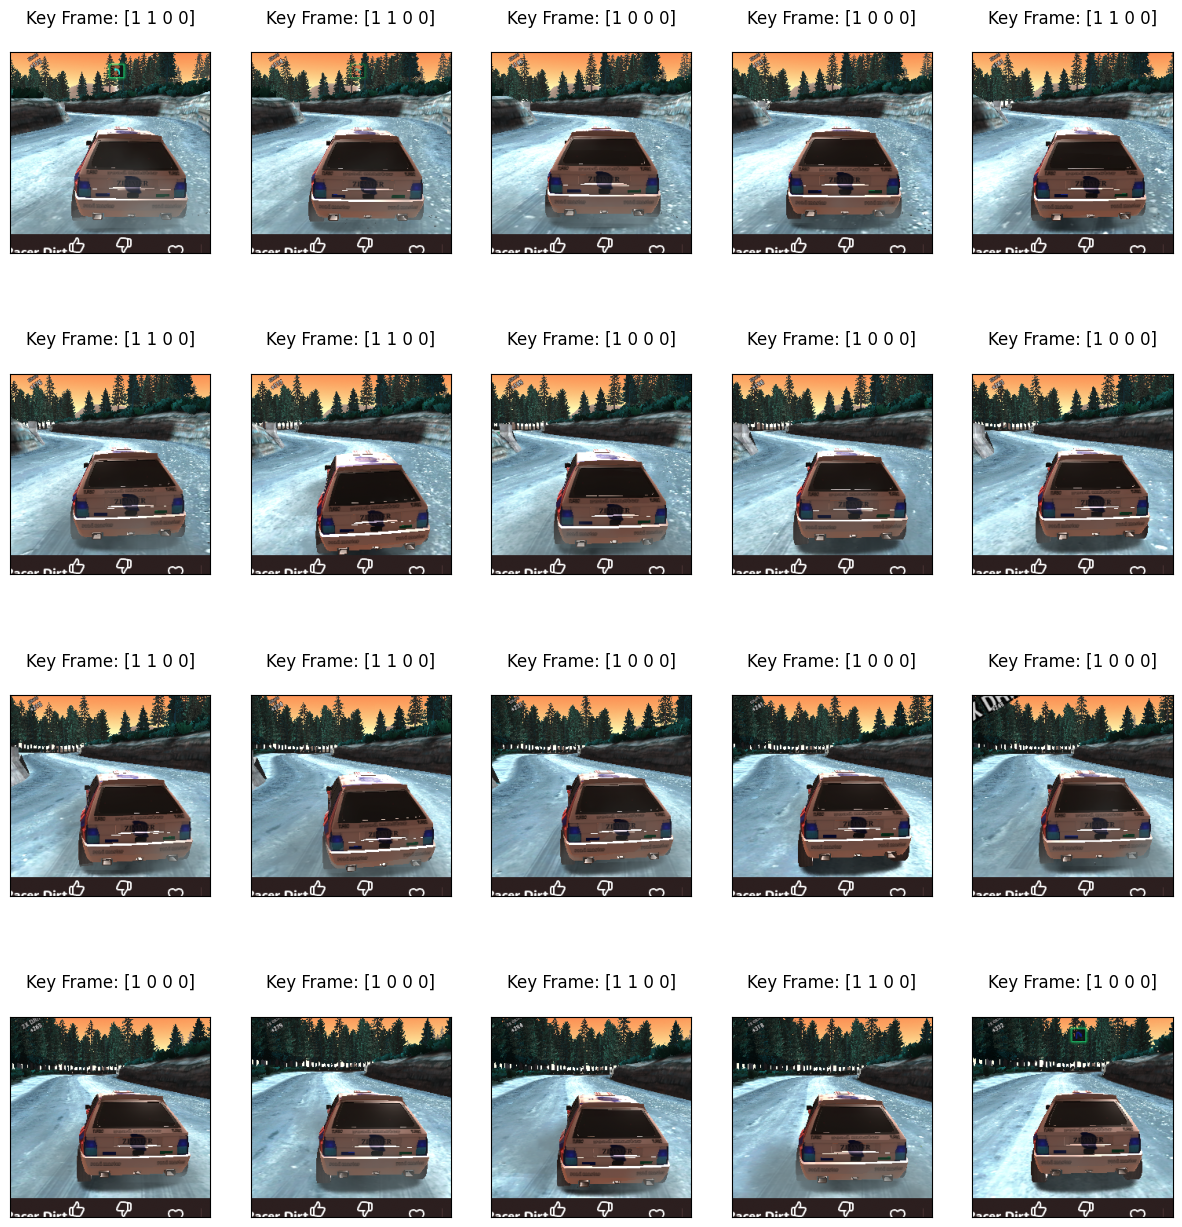

In [12]:
show_recording(recording, start_frame=100, n=20)

In this recording we can see the images and key states from left to right, top to bottom, that play the movie of this section of the recording. The key states above each image show which keys were pressed at that time step. In this example we see me driving around a left curve, holding on the forward arrow key and tapping the left arrow key to turn left.  

# Imitation Learning

Although there are many different ways that you can create a model to predict a correct action given some environment, we will use a technique known as Imitation Learning to train our model to behave as we would given the same environment. This approach turns the problem into a simple **supervised learning** problem with the input being the image frames and the output being the key state. The idea is that if we can control the vehicle successfully from visual data alone, we can train a model to imitate these controls based off of the images that it sees.


# Inputs and Outputs

The state that the recordings are in right now aren't ready to be trained on. We have to split the recordings up into examples with an input $X$ and an output $y$ so that we can train a model with these examples. The input in this case will be a `window_size` of image frames, and the output will be the key state array signifying which keys should be pressed at that instant.

The way that we will extract this data from our recordings will be through a process called **segmentation**. We will segment the recording by passing a window of size `window_size` over our recordings one time step at a time. Each step we will make a copy of the screen and key frames in that window. We will use all of the copied screen frames in that window to be the input, and the last key frame in the window to be the output. We will use this input and output pair to create an example. Then we will proceed to slide the window over by one frame and do the process all over again to make another example. We'll do this over and over till we've made an example out of every frame in the recording.


# Indexing Examples

A problem that I ran into while evaluating my model was that it was tending to always predict going straight and not turning. I deduced that this was because I was feeding my model all of the examples from the recordings, where a majority of them were straight. To mitigate this I added the index function to categorize each example into a direction class. That way I can use this index to sample an even distribution of examples from each class. After changing my sample to use a balanced amount of each class the model was able to predict turning much better.


#The Memory Problem

Before we run this code, it is important to realize that the memory usage that comes with working with video data is remarkably high. For example, a 40 second recording of 256 x 256 RGB images taken at 10 fps is...

$$40s * 10fps * 256 * 256 * 3 * 8 bytes = 630 Mb$$

Then segmenting the data effectively multiplies this amount by your window size. So the size after segmenting with a window size of 20 is...

$$20 * 630 mb = 12.6 Gb$$

Each recording can take around 12 Gb of RAM at a time. So our segmenting process must account for this kind of data flow. Even designing this in a google colab notebook where you can choose to run on a machine with higher ram (eg. 50Gb) we will process no more than one recording at a time.

###Generators
Luckily, python generators allow you to design loops that help you manage memory efficiently. Generators create an iterable list that loads the next value in a sequence only when it's needed then properly discards it. We will use a generator to load one recording at a time so that we stay within our available memory usage.

### Hard Drive Space
This process is rather hard drive extensive, I will admit. First we obviously need to save our recordings on disk. Then we need to make our segmented examples and save those to disk, which, as we saw, multiplies the size of the recordings by the window size. Then in order to make our training pipeline more efficient we need to create batching files which will effectively make a copy of all the examples, batch them together, and save the batches to disk.

In my case, I recorded around 50 recordings, each around 40 seconds in length and from start to finish it uses about a terabyte of space. You may delete previous sets of data once the processing of that step has completed to save on space if you prefer.

Now with that out of the way let's get back to the code!


### Recordings Generator

In [13]:
def create_recordings_generator(recording_file_paths):
  """
  Creates a generator function to load and return recording objects
  from a particular directory
  ARGS:
    recording_file_paths (list): List of recording file paths
  RETURNS:
    (generator)
    recording (dict): Recording
  """
  # Loop through recording file paths
  for recording_file_path in recording_file_paths:
    # Load recording
    print(f"Processing {recording_file_path}...")
    recording = load_pickle_object(recording_file_path)
    # Yield recording
    yield recording

### Segment Recording

In [14]:
def segment_recording(recording, window_size=20, step_size=1):
  """
  First normalizes video data then segments screen and key recordings
  into segments. Pads begining of recordings with zeros to make all
  segments the same length.
  ARGS:
    recording (dict): Recording with screen_frames and key_frames
    window_size (int): Window size
    step_size (int): Step size, how far to adjust window each itteration
  RETURNS:
    (tuple)
    screen_segments (numpy array): Screen segments
    key_segments (numpy array): Key segments
  """
  # Get frames
  screen_frames = recording['screen_frames']
  # Normalize screen_frames
  screen_frames = screen_frames / 255.0
  key_frames = recording['key_frames']
  # Get number of frames
  num_frames = len(screen_frames)
  # Add blank padding to begining of recordings
  screen_frames = np.concatenate((np.zeros((window_size - 1, screen_frames.shape[1], screen_frames.shape[2], screen_frames.shape[3]), dtype=int), screen_frames))
  key_frames = np.concatenate((np.zeros((window_size - 1, key_frames.shape[1]), dtype=int), key_frames))
  # Loop through frames steping by step size to collect segments
  screen_segments = []
  key_segments = []
  for i in range(0, num_frames, step_size):
    # Append segments
    screen_segments.append(screen_frames[i:i+window_size])
    key_segments.append(key_frames[i:i+window_size])
  np_screen_segments = np.array(screen_segments)
  np_key_segments = np.array(key_segments)
  del screen_frames
  del key_frames
  # Return
  return np_screen_segments, np_key_segments

### Create Segments Generator

In [15]:
def create_segments_generator(recordings, window_size=20, step_size=1):
  """
  Creates a generator function to return segments from recordings
  ARGS:
    recordings (list): List of recordings
    window_size (int): Window size
    step_size (int): Step size, how far to adjust window each itteration
  RETURNS:
    (generator)
    screen_segment, key_segment (numpy array, numpy array): A single pair of screen and key segments
  """
  # Loop through recordings
  for recording in recordings:
    # Segment recording
    screen_segments, key_segments = segment_recording(recording, window_size=window_size, step_size=step_size)
    for screen_segment, key_segment in zip(screen_segments, key_segments):
      # Yield segments
      yield screen_segment, key_segment

### Create Example

In [16]:
def create_example(screen_segment, key_segment):
  """
  Creates an example from screen and key segments
  ARGS:
    screen_segment (numpy array): Screen segment
    key_segment (numpy array): Key segment
  RETURNS:
    example (dict): Dictionary with x_screen_frames, x_key_frames, y_key_state
  """
  # Get label
  label_key_state = key_segment[-1]
  # Create example
  example = {
      'x_screen_frames': screen_segment,
      'x_key_frames': key_segment[:-1],
      'y_key_state': label_key_state
  }
  # Return
  return example

### Index Example

In [17]:
def index_example(index_dict, example, example_file_name):
  """
  Indexes example file name to label class
  ARGS:
    index_dict (dict): index dictionary
    example (dict): Example
    example_file_name (str): Example file name
  """
  # Check for index keys
  if 'forwards' not in index_dict:
    index_dict['forwards'] = []
  if 'left_turn' not in index_dict:
    index_dict['left_turn'] = []
  if 'right_turn' not in index_dict:
    index_dict['right_turn'] = []
  if 'backwards' not in index_dict:
    index_dict['backwards'] = []
  if 'coast' not in index_dict:
    index_dict['coast'] = []

  # Get label
  label_key_state = example['y_key_state']

  # If forwards
  if label_key_state[0] == 1:
    index_dict['forwards'].append(example_file_name)
  # If left turn
  if label_key_state[1] == 1:
    index_dict['left_turn'].append(example_file_name)
  # If right turn
  if label_key_state[2] == 1:
    index_dict['right_turn'].append(example_file_name)
  # If backwards
  if label_key_state[3] == 1:
    index_dict['backwards'].append(example_file_name)
  # If coast
  if not label_key_state.any():
    index_dict['coast'].append(example_file_name)

### Create Examples

In [18]:
def create_examples(examples_dir, recording_file_paths, window_size=20, step_size=1):
  """
  Creates examples and saves them as pickle files in examples_dir
  ARGS:
    examples_dir (str): Directory to save examples
    recording_file_paths (list): List of recording file paths
    window_size (int): Window size
    step_size (int): Step size
  """
  # Initialize index dictionary
  index_dict = {}
  example_count = 1

  # Create recordings generator
  recordings = create_recordings_generator(recording_file_paths)

  # Create segments generator
  segments = create_segments_generator(
      recordings,
      window_size=window_size,
      step_size=step_size
      )

  # Loop through segments
  for screen_segment, key_segment in segments:
    # Create example
    example = create_example(screen_segment, key_segment)
    # Create file name
    filename = f"example_{str(example_count).zfill(8)}.pickle"
    example_count += 1
    example_path = os.path.join(examples_dir, filename)
    # Save example
    save_pickle_object(example, example_path)
    # Index example
    index_example(index_dict, example, filename)

  # Save index dictionary
  index_path = os.path.join(examples_dir, "index.pickle")
  save_pickle_object(index_dict, index_path)
  print(f"Created index file {index_path}")

  example_file_paths = get_pickle_file_paths(examples_dir)
  print(f"Created {len(example_file_paths) - 1} examples")
  print('Done!')


# Create examples!

This code might take a while if you have a large amount of recordings. But the output from this function will tell you which recording you are currently processing.


In [19]:
create_examples(
    examples_dir=examples_dir,
    recording_file_paths=recording_file_paths,
    window_size=window_size,
    step_size=step_size
)

Processing /content/drive/MyDrive/Projects/AutonomousGamePlayer/RallyRacerDirtRecordings/recording_1710211516.pickle...
Processing /content/drive/MyDrive/Projects/AutonomousGamePlayer/RallyRacerDirtRecordings/recording_1710211907.pickle...
Processing /content/drive/MyDrive/Projects/AutonomousGamePlayer/RallyRacerDirtRecordings/recording_1710212254.pickle...
Created index file /content/drive/MyDrive/Projects/AutonomousGamePlayer/Examples/index.pickle
Created 1342 examples
Done!


# You've created your examples!

If you have a look in your `examples_dir` you should see all of the examples saved there. As you can see they are just pickle files containing a dictionary with the keys `x_screen_frames`, `x_key_frames`, `y_key_state`. The 'x' prefix indicates the input variables that we can use and the 'y' prefix indicates the output or target variable of the example.


# Index file
But before we look at a specific example, we will open up the index file to see how the examples got categorized.

In [20]:
index_path = os.path.join(examples_dir, "index.pickle")
index = load_pickle_object(index_path)
print(f'Index keys: {index.keys()}')

Index keys: dict_keys(['forwards', 'left_turn', 'right_turn', 'backwards', 'coast'])


In [21]:
print(f"Forwards Examples: {len(index['forwards'])}")
print(f"Left Turn Examples: {len(index['left_turn'])}")
print(f"Right Turn Examples: {len(index['right_turn'])}")
print(f"Backwards Examples: {len(index['backwards'])}")
print(f"Coast Examples: {len(index['coast'])}")

Forwards Examples: 963
Left Turn Examples: 307
Right Turn Examples: 270
Backwards Examples: 0
Coast Examples: 109


In [22]:
index['left_turn'][:5]

['example_00000009.pickle',
 'example_00000010.pickle',
 'example_00000028.pickle',
 'example_00000037.pickle',
 'example_00000038.pickle']

Here we see how our examples got categorized into `forwards`, `left_turn`, `right_turn`, `backwards`, and `coast`. Let's have a look at a left turn example.

# Show example function

In [23]:
def show_example(example_file_path):
  """
  Shows an example
  ARGS:
    example_file_path (str): Path to example file
  """
  example = load_pickle_object(example_file_path)
  x_screen_frames = example['x_screen_frames']
  key_states = [str(key_state) for key_state in example['x_key_frames']]
  y_key_state = f"Target {str(example['y_key_state'])}"
  key_states.append(y_key_state)
  display_images(x_screen_frames, labels=key_states, label_title='Key State', n=len(x_screen_frames))

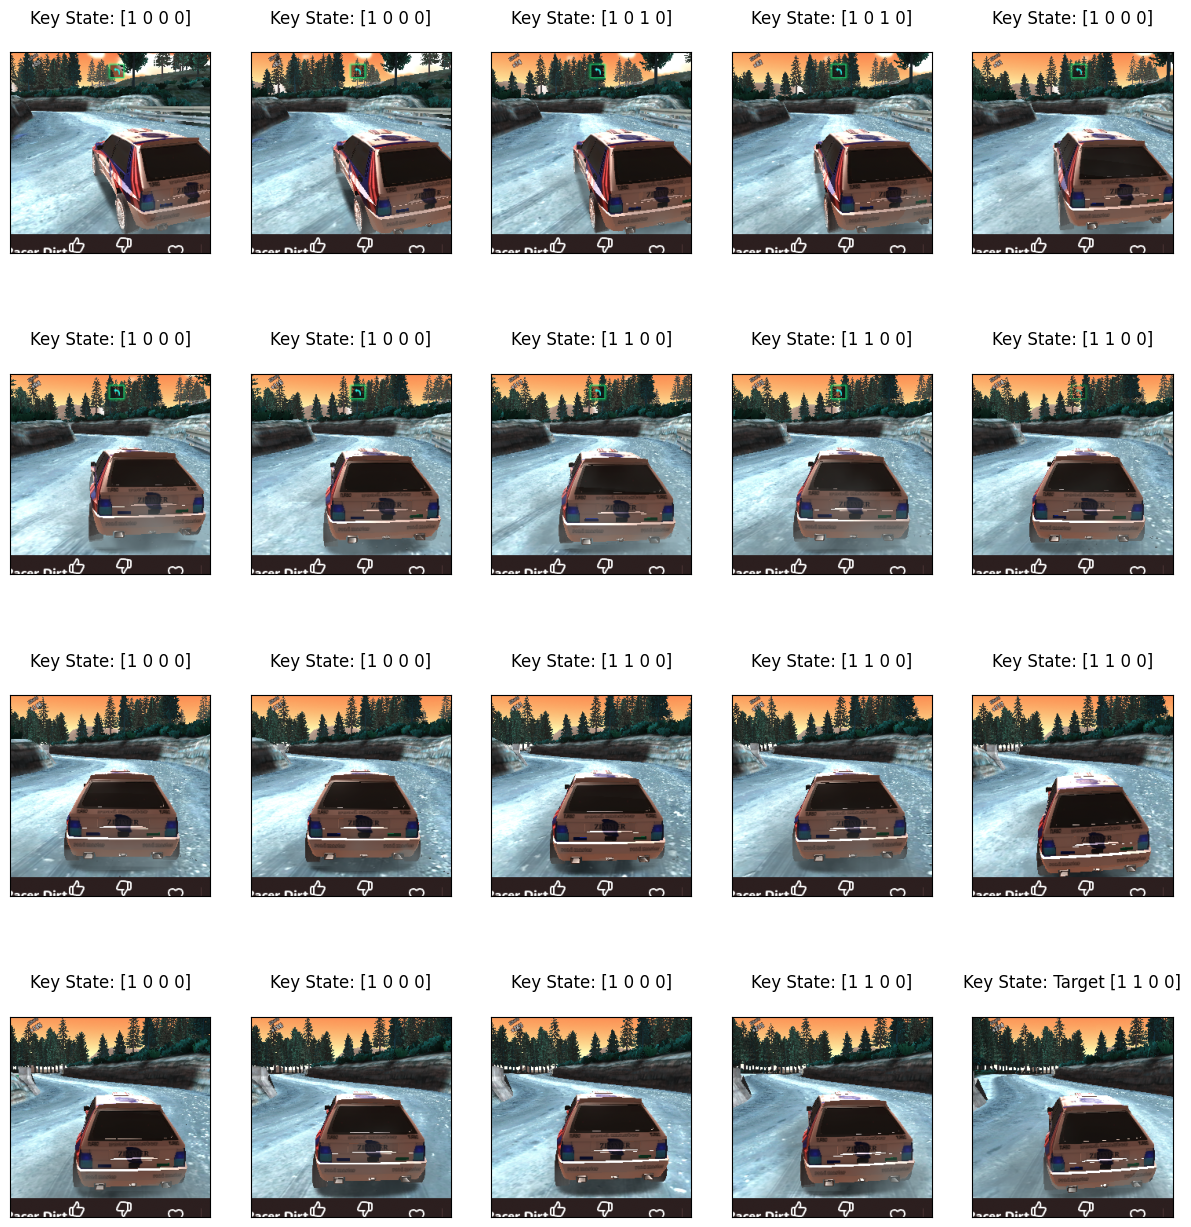

In [24]:
example_file_name = index['left_turn'][100]
example_path = os.path.join(examples_dir, example_file_name)
show_example(example_path)

Notice that the last image's key state is our target keystate that we would like our model to predict.

# Sampling
Now we will look at how we can create the best set of data for our model. Just because we have all of the data doesn't mean that we should use it. In our case we want to sample a balanced dataset from the available dataset so that our model doesn't learn to prefer a single label over the others.


### Sample from index

In [25]:
def sample_from_index(index):
  """
  Combines the following into a single list.
  - All left, right, backwards and coast  examples.
  - Equal number of forward examples to the max turn examples.
  ARGS:
    index (dict): the index dict with forwards, left_turn, right_turn, backwards and coast keys
  RETURNS:
    sample (list): the randomized sample
  """
  # Create sample list
  sample = []
  # Add left, right, backwards, and cost examples
  sample.extend(index['left_turn'])
  sample.extend(index['right_turn'])
  sample.extend(index['backwards'])
  sample.extend(index['coast'])
  # Get randomized list of forwards examples
  forwards = np.array(index['forwards'])
  np.random.shuffle(forwards)
  # Get the max of left or right turns
  max_turn = max(len(index['left_turn']), len(index['right_turn']))
  # Get max_turn number of examples from randomized forwards examples
  sample.extend(forwards[:max_turn])
  # Shuffle sample
  np.random.shuffle(sample)
  return sample

In [26]:
sample = sample_from_index(index)
print(f"Sample size: {len(sample)}")

Sample size: 993


# Up and Down Sampling
You can see that our sampled dataset size is only 993 compared to the 1342 total examples that we created from our recordings. This is because we down sampled the majority class, that being the forwards class, to balance the minority classes, being the left turn, right turn, backwards, and coast classes.

I won't show the code, but here would be a good place if you decided that your model needed some additional augmented data to up sample your minority classes. You can do this for instance by flipping the image horizontally to double your turning examples. Just remember if you do, your left turn examples become right turns and vice versa.


# Append file path to files

We'll need our sample list to include its full path in a future step, so we'll do that now.


In [27]:
def add_file_path_to_file_names(dir_path, file_names):
  """
  Add file path to file names
  ARGS:
    dir_path (string): path of the directory
    file_names (list): the file names
  RETURNS:
    full_file_names (list): the full file names
  """
  full_file_names = []
  for file_name in file_names:
    full_file_names.append(os.path.join(dir_path, file_name))
  return full_file_names

In [28]:
sample = add_file_path_to_file_names(examples_dir, sample)

# Train, Validate, and Tests Sets!

A udemy course on machine learning once told me, "The most important concept in machine learning is the train, validation and test sets”. So now that we have our balanced dataset, we can split up our data.

### Batch size

Before we get to that, another important number that we'll start seeing from now on is the `batch_size`. The `batch_size` is the amount of examples that we'll send through our model at a time. A higher batch size is usually better because it smooths out the gradient, making it easier for the model to generalize patterns. However, especially because we are working with video data, the higher the batch size, the more load we put on the GPU at once, and could therefore overload the GPU causing errors during training, which we don't want to happen. The highest `batch_size` that I was able to use was `32` in my case.


In [29]:
def get_train_val_test_sets(all_file_paths, train_size, val_size, test_size, batch_size, data_portion=1.0):
  """
  Get train, validation, and test sets
  ARGS:
    all_file_paths (list): the list of all file paths
    train_size (float): the train size proportion
    val_size (float): the validation size proportion
    test_size (float): the test size proportion
    batch_size (int): the batch size
    data_portion (float): the data portion
  RETURNS:
    train_file_paths (list): the list of train file paths
    val_file_paths (list): the list of validation file paths
    test_file_paths (list): the list of test file paths
  """
  # Portion the data
  all_file_paths = all_file_paths[:int(data_portion * len(all_file_paths))]

  # Validate that train, val, and test, sizes add up to 1
  assert train_size + val_size + test_size == 1

  # Number of files for each set
  train_size = int(train_size * len(all_file_paths))
  val_size = int(val_size * len(all_file_paths))
  test_size = int(test_size * len(all_file_paths))

  # Get the file sets
  train_file_paths = all_file_paths[:train_size]
  val_file_paths = all_file_paths[train_size:train_size + val_size]
  test_file_paths = all_file_paths[train_size + val_size:]

  # Limit the size of the sets to be a multiple of batch_size
  batched_train_size = int(len(train_file_paths) / batch_size) * batch_size
  batched_val_size = int(len(val_file_paths) / batch_size) * batch_size
  batched_test_size = int(len(test_file_paths) / batch_size) * batch_size

  # Get the file sets
  train_file_paths = train_file_paths[:batched_train_size]
  val_file_paths = val_file_paths[:batched_val_size]
  test_file_paths = test_file_paths[:batched_test_size]

  # Shuffle the sets
  np.random.shuffle(train_file_paths)
  np.random.shuffle(val_file_paths)
  np.random.shuffle(test_file_paths)

  return train_file_paths, val_file_paths, test_file_paths

In [30]:
train_file_paths, val_file_paths, test_file_paths = get_train_val_test_sets(sample, train_size=0.8, val_size=0.1, test_size=0.1, batch_size=batch_size)
print(f"Train size: {len(train_file_paths)}")
print(f"Val size: {len(val_file_paths)}")
print(f"Test size: {len(test_file_paths)}")

Train size: 768
Val size: 96
Test size: 96


# Batching

Our last step in this process is to batch our examples together to improve the efficiency of our training pipeline.


### Load examples from files

In [31]:
def load_examples_from_files(file_paths):
  """
  Load examples from files
  ARGS:
    file_paths (list): the list of files paths
  RETURNS:
    examples (list): the list of examples
  """
  examples = []
  with Pool() as pool:
    examples = pool.map(load_pickle_object, file_paths)
  return examples

### Examples Generator

In [32]:
def examples_generator(file_paths, batch_size):
  """
  Example generator
  ARGS:
    file_paths (list): the list of file paths
    batch_size (int): the batch size
  RETURNS:
    examples (list): the example
  """
  for i in range(0, len(file_paths), batch_size):
    examples = load_examples_from_files(file_paths[i:i + batch_size])
    yield examples

### Create batched files

In [33]:
def create_batched_files(file_paths, batch_size, save_dir):
  """
  Create batched files
  ARGS:
    file_paths (list): the list of file paths
    batch_size (int): the batch size
    save_dir (str): the save directory
  """
  example_batch_generator = examples_generator(file_paths, batch_size)
  for i, example_batch in enumerate(example_batch_generator):
    example_batch_file_path = os.path.join(save_dir, f"example_batch_{i}.pickle")
    save_pickle_object(example_batch, example_batch_file_path)

In [34]:
# Create directories if they don't exists
train_dir = batched_examples_dir + '/train'
val_dir = batched_examples_dir + '/val'
test_dir = batched_examples_dir + '/test'

if not os.path.exists(train_dir):
    os.makedirs(train_dir)
if not os.path.exists(val_dir):
    os.makedirs(val_dir)
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

In [35]:
# Train files
create_batched_files(train_file_paths, batch_size, train_dir)

# Val files
create_batched_files(train_file_paths, batch_size, val_dir)

# Test files
create_batched_files(test_file_paths, batch_size, test_dir)

# DONE!

Well done! You have completed the oftentimes most time consuming and difficult aspect of machining learning, the preprocessing! You should now have all of your data ready to be trained with in batch files. So once you're ready we can move on the to next step, THE TRAINING 🏋️
